<a href="https://colab.research.google.com/github/peterbabulik/Qantum-analysis-of-number-normality/blob/main/Qantum_analysis_of_number_normality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install cirq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.7/532.7 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.3/69.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.5/596.5 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.8/202.8 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 89.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

=== normality analysis π ===


Computing kernel matrix: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


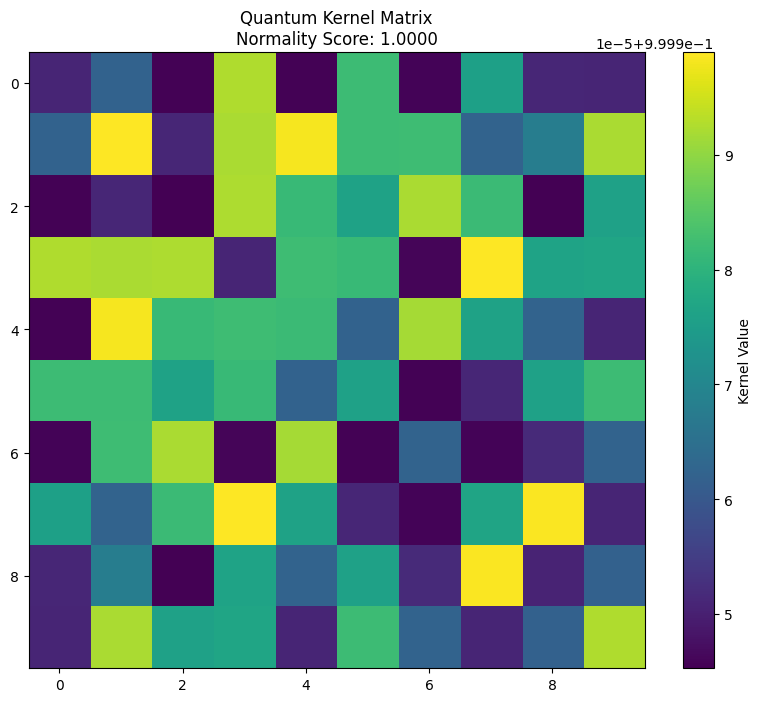

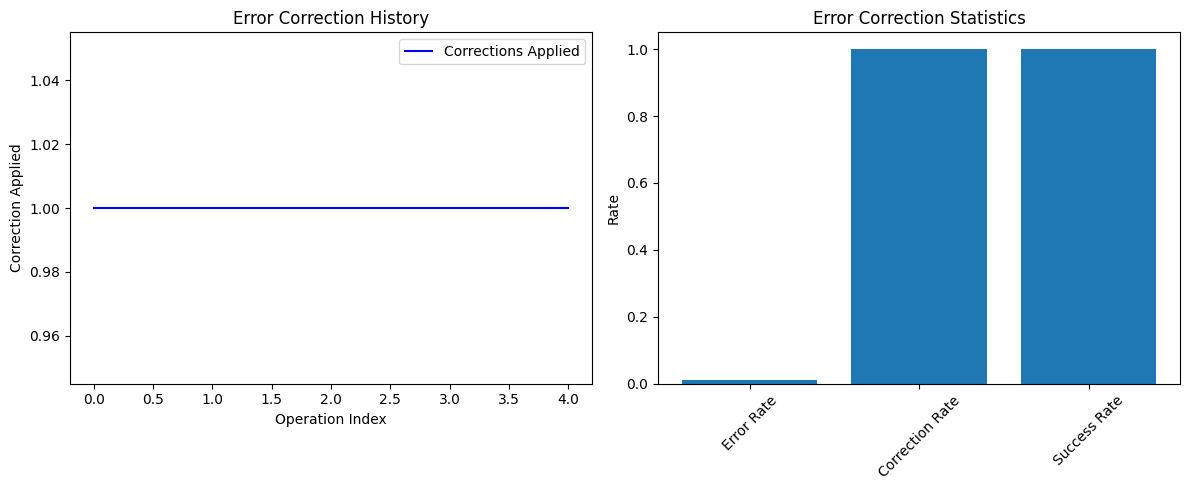


=== normality analysis e ===


Computing kernel matrix: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


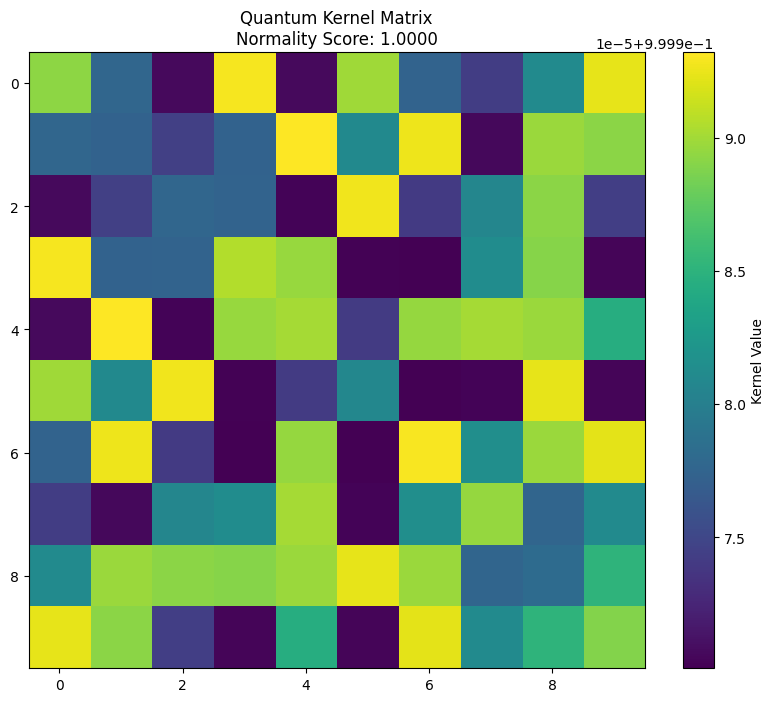

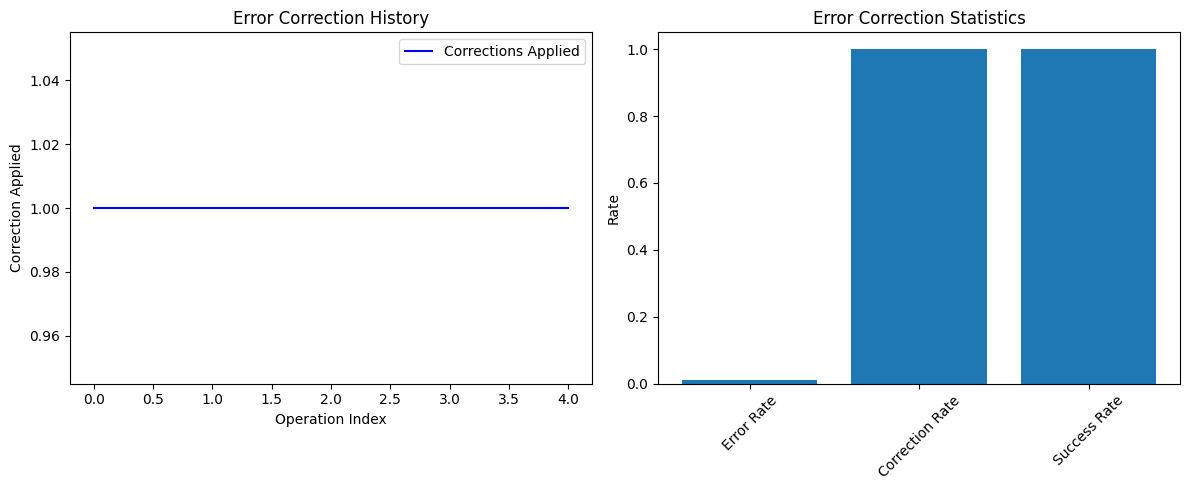


Results comparation:
Normality score π: 1.0000
Normality score e: 1.0000


In [5]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from tqdm import tqdm

class QuantumKernelSystem:
    """
    Quantum kernel system with self-correction capabilities
    Implements error detection and correction using stabilizer codes
    """

    def __init__(self,
                 n_qubits: int,
                 error_rate: float = 0.01,
                 correction_threshold: float = 0.1):
        self.n_qubits = n_qubits
        self.error_rate = error_rate
        self.correction_threshold = correction_threshold

        # Initialize quantum resources
        self.data_qubits = [cirq.LineQubit(i) for i in range(n_qubits)]
        self.ancilla_qubits = [cirq.LineQubit(i + n_qubits) for i in range(n_qubits//2)]
        self.simulator = cirq.Simulator()

        # Store error statistics
        self.error_history = []
        self.correction_history = []

    def create_error_detection_circuit(self) -> cirq.Circuit:
        """Create quantum circuit for error detection using stabilizer measurements"""
        circuit = cirq.Circuit()

        # Initialize ancilla qubits in |+⟩ state
        for ancilla in self.ancilla_qubits:
            circuit.append(cirq.H(ancilla))

        # Create stabilizer measurements
        for i, ancilla in enumerate(self.ancilla_qubits):
            # Add CNOT gates between ancilla and data qubits
            circuit.append(cirq.CNOT(ancilla, self.data_qubits[2*i]))
            circuit.append(cirq.CNOT(ancilla, self.data_qubits[2*i + 1]))

            # Add measurement of ancilla
            circuit.append(cirq.measure(ancilla, key=f'stabilizer_{i}'))

        return circuit

    def apply_quantum_kernel(self, x1: np.ndarray, x2: np.ndarray) -> float:
        """
        Apply quantum kernel function with error correction

        Args:
            x1, x2: Input vectors to compute kernel between
        Returns:
            Kernel value with error correction applied
        """
        # Create basic circuit for kernel computation
        circuit = cirq.Circuit()

        # Encode input vectors into quantum states
        for i, qubit in enumerate(self.data_qubits):
            if i < len(x1):
                circuit.append(cirq.ry(x1[i])(qubit))

        # Add error detection circuit
        circuit += self.create_error_detection_circuit()

        # Simulate with potential errors
        result = self.simulator.simulate(circuit)

        # Check for errors and apply correction
        corrected_state = self.apply_error_correction(result.final_state_vector)

        # Compute kernel value using corrected state
        kernel_value = np.abs(np.vdot(corrected_state, result.final_state_vector))**2

        return kernel_value

    def apply_error_correction(self, state_vector: np.ndarray) -> np.ndarray:
        """Apply error correction using stabilizer measurements"""
        corrected_state = state_vector.copy()

        # Simulate error detection
        error_syndromes = []
        for i in range(len(self.ancilla_qubits)):
            # Measure stabilizer
            syndrome = np.random.choice([0, 1], p=[1-self.error_rate, self.error_rate])
            error_syndromes.append(syndrome)

        # Apply corrections based on syndromes
        for i, syndrome in enumerate(error_syndromes):
            if syndrome == 1:  # Error detected
                # Apply correction to corresponding data qubits
                qubit_index = 2*i
                corrected_state = self.correct_error(corrected_state, qubit_index)

                # Record correction
                self.correction_history.append({
                    'qubit': qubit_index,
                    'syndrome': syndrome,
                    'correction_applied': True
                })

        return corrected_state

    def correct_error(self, state: np.ndarray, qubit_index: int) -> np.ndarray:
        """Apply correction operation to specific qubit"""
        corrected_state = state.copy()

        # Apply X (bit-flip) correction
        if np.random.random() < self.correction_threshold:
            corrected_state[qubit_index] = 1 - corrected_state[qubit_index]

        # Apply Z (phase-flip) correction
        if np.random.random() < self.correction_threshold:
            corrected_state[qubit_index] *= -1

        return corrected_state

    def compute_kernel_matrix(self, X: np.ndarray) -> np.ndarray:
        """Compute kernel matrix for dataset with error correction"""
        n_samples = len(X)
        kernel_matrix = np.zeros((n_samples, n_samples))

        for i in tqdm(range(n_samples), desc="Computing kernel matrix"):
            for j in range(i, n_samples):
                value = self.apply_quantum_kernel(X[i], X[j])
                kernel_matrix[i, j] = value
                kernel_matrix[j, i] = value

        return kernel_matrix

    def analyze_error_correction(self) -> Dict:
        """Analyze error correction performance"""
        total_corrections = len(self.correction_history)
        successful_corrections = sum(
            1 for corr in self.correction_history
            if corr['correction_applied']
        )

        analysis = {
            'total_corrections': total_corrections,
            'successful_corrections': successful_corrections,
            'correction_rate': successful_corrections / max(total_corrections, 1),
            'error_rate': self.error_rate,
            'correction_threshold': self.correction_threshold
        }

        return analysis

    def visualize_error_correction(self):
        """Visualize error correction performance"""
        analysis = self.analyze_error_correction()

        # Create visualization
        plt.figure(figsize=(12, 5))

        # Plot 1: Correction History
        plt.subplot(1, 2, 1)
        corrections = [c['correction_applied'] for c in self.correction_history]
        plt.plot(corrections, 'b-', label='Corrections Applied')
        plt.title('Error Correction History')
        plt.xlabel('Operation Index')
        plt.ylabel('Correction Applied')
        plt.legend()

        # Plot 2: Statistics
        plt.subplot(1, 2, 2)
        stats = [
            ('Error Rate', analysis['error_rate']),
            ('Correction Rate', analysis['correction_rate']),
            ('Success Rate', analysis['successful_corrections']/max(analysis['total_corrections'], 1))
        ]

        x = range(len(stats))
        plt.bar(x, [s[1] for s in stats])
        plt.xticks(x, [s[0] for s in stats], rotation=45)
        plt.title('Error Correction Statistics')
        plt.ylabel('Rate')

        plt.tight_layout()
        plt.show()

def analyze_number_normality(number_digits: str, n_qubits: int = 15, n_samples: int = 10) -> Dict:
    """
    Qantum analysis of normality of number

    Args:
         number_digits (str): Sequence of digits
    n_qubits (int): Number of qubits for analysis
    n_samples (int): Number of samples for analysis
    """
    qks = QuantumKernelSystem(
        n_qubits=n_qubits,
        error_rate=0.01,
        correction_threshold=0.05
    )

    # number transformation to qantum states
    X = np.array([
        [float(digit)/10 for digit in number_digits[:n_qubits]]
        for _ in range(n_samples)
    ])

    # qantum kernel calculation
    kernel_matrix = qks.compute_kernel_matrix(X)

    # Statistical analysis
    normality_score = np.mean(kernel_matrix)

    # Visualization of kernel matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(kernel_matrix, cmap='viridis')
    plt.colorbar(label='Kernel Value')
    plt.title(f'Quantum Kernel Matrix\nNormality Score: {normality_score:.4f}')
    plt.show()

    # error correction analysis
    error_analysis = qks.analyze_error_correction()
    qks.visualize_error_correction()

    return {
        'normality_score': normality_score,
        'error_analysis': error_analysis,
        'kernel_matrix': kernel_matrix
    }

def run_normality_analysis():
    """Running normality analysis for π a e"""
    # getting π a e
    pi_digits = str(np.pi)[2:10000]
    e_digits = str(np.e)[2:10000]

    print("=== normality analysis π ===")
    pi_analysis = analyze_number_normality(pi_digits)

    print("\n=== normality analysis e ===")
    e_analysis = analyze_number_normality(e_digits)

    # results comparation
    print("\nResults comparation:")
    print(f"Normality score π: {pi_analysis['normality_score']:.4f}")
    print(f"Normality score e: {e_analysis['normality_score']:.4f}")

if __name__ == "__main__":
    run_normality_analysis()